# 📊 Telegram Sentiment Analysis

Simple and powerful sentiment analysis with beautiful visualizations.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from btc_sentiment.pipelines.ingest_pipeline import run_simple_analysis
from btc_sentiment.utils.analysis import load_and_prepare_data

# Beautiful styling
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12
%matplotlib inline

## 🚀 Run Analysis

Choose your analysis period and run sentiment analysis.

🎯 Running sentiment analysis for last 1095 days...
📈 Running simple analysis for 1095 day(s)
📅 Period: 2022-09-08 to 2025-09-07
📥 Fetching from group -1001305631383 (1/1)...
✅ Successfully connected to supergroup: Market Mercenaries
📊 Group has None members
✅ Successfully fetched 16077 messages from -1001305631383
📊 Analyzing 16077 messages...
Saved 121 records to data/processed/daily_sentiment_20250907_151610.parquet


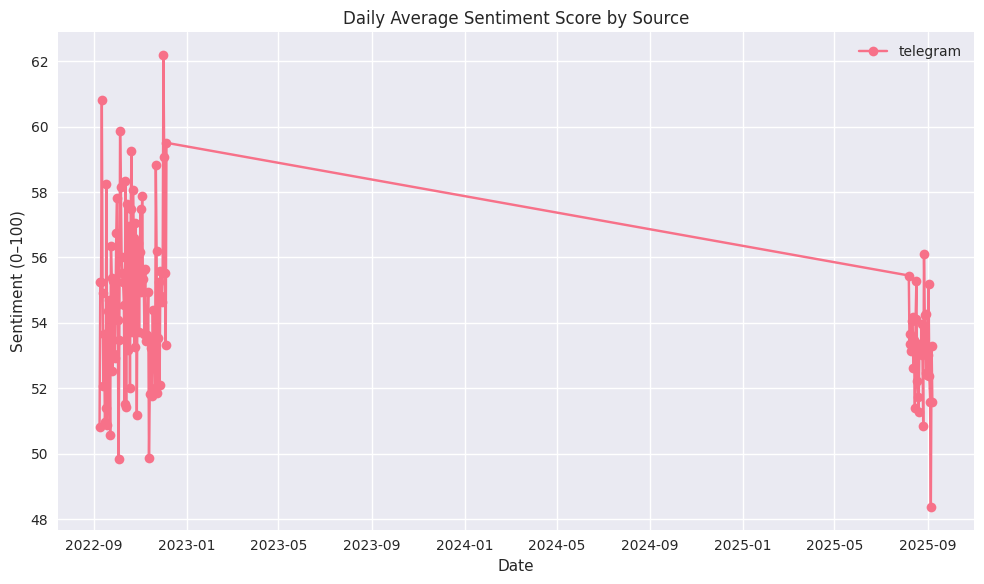

✅ Analysis complete! 121 daily records generated
✅ Loaded 121 daily records
📅 Period: 2022-09-08 to 2025-09-07
💬 Total messages: 16,077


,date,source,avg_score,count,label
0,2022-09-08,telegram,50.814737,38,neutral
1,2022-09-09,telegram,55.262430,107,neutral
2,2022-09-10,telegram,55.251923,52,neutral
3,2022-09-11,telegram,60.801724,29,neutral
4,2022-09-12,telegram,54.914000,40,neutral
...,...,...,...,...,...
116,2025-09-03,telegram,52.378278,90,neutral
117,2025-09-04,telegram,51.594660,147,neutral
118,2025-09-05,telegram,48.366311,206,neutral
119,2025-09-06,telegram,53.279794,97,neutral


In [2]:
import nest_asyncio
nest_asyncio.apply()
# Set analysis period (change this to your desired timeframe)
DAYS_BACK = 1095  # Last 3 years 

print(f'🎯 Running sentiment analysis for last {DAYS_BACK} days...')

# Run the analysis
daily_records = run_simple_analysis(days_back=DAYS_BACK)

# Load the results
df = load_and_prepare_data()

if df.empty:
    print('❌ No data available')
    print('💡 Check your Telegram credentials and group access')
else:
    print(f'✅ Loaded {len(df)} daily records')
    print(f'📅 Period: {df["date"].min().strftime("%Y-%m-%d")} to {df["date"].max().strftime("%Y-%m-%d")}')
    print(f'💬 Total messages: {df["count"].sum():,}')
    display(df)

## 📈 Beautiful Sentiment Dashboard

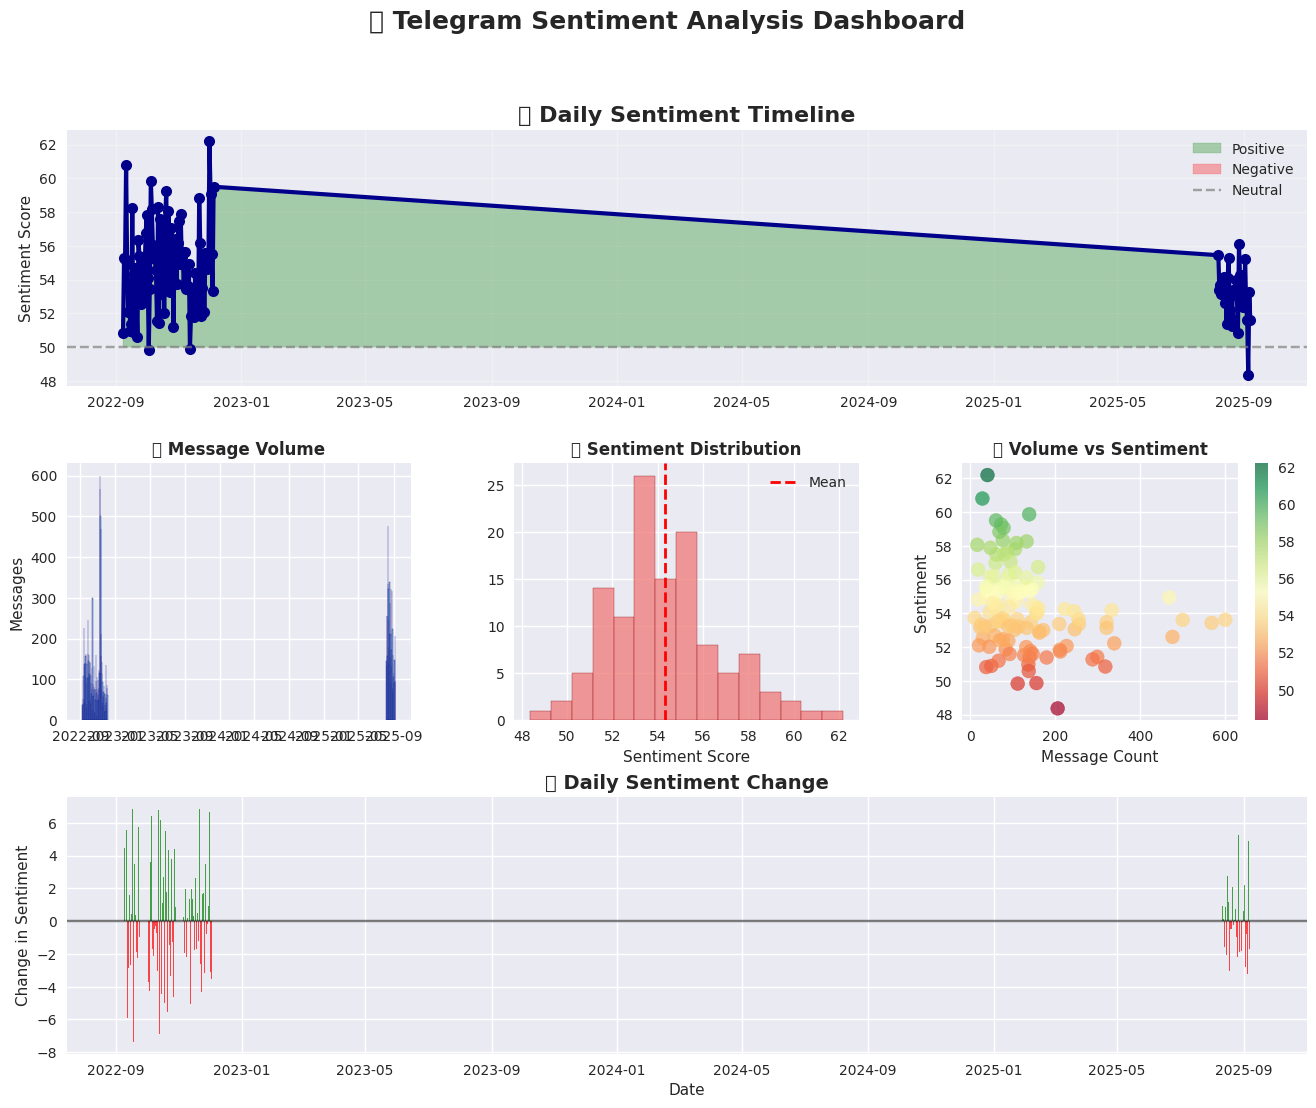

In [3]:
if not df.empty:
    # Create stunning dashboard
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)
    
    # 1. Main sentiment timeline (spans 2 columns)
    ax1 = fig.add_subplot(gs[0, :])
    colors = ['red' if x < 50 else 'green' for x in df['avg_score']]
    ax1.plot(df['date'], df['avg_score'], marker='o', linewidth=3, markersize=8, color='darkblue')
    ax1.fill_between(df['date'], df['avg_score'], 50, alpha=0.3, 
                     where=(df['avg_score'] >= 50), color='green', label='Positive')
    ax1.fill_between(df['date'], df['avg_score'], 50, alpha=0.3, 
                     where=(df['avg_score'] < 50), color='red', label='Negative')
    ax1.axhline(y=50, color='gray', linestyle='--', alpha=0.7, label='Neutral')
    ax1.set_title('📊 Daily Sentiment Timeline', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Sentiment Score')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Message volume bars
    ax2 = fig.add_subplot(gs[1, 0])
    bars = ax2.bar(df['date'], df['count'], alpha=0.8, color='skyblue', edgecolor='navy')
    ax2.set_title('💬 Message Volume', fontweight='bold')
    ax2.set_ylabel('Messages')
    
    # 3. Sentiment distribution
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.hist(df['avg_score'], bins=15, alpha=0.8, color='lightcoral', edgecolor='darkred')
    ax3.axvline(df['avg_score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
    ax3.set_title('📈 Sentiment Distribution', fontweight='bold')
    ax3.set_xlabel('Sentiment Score')
    ax3.legend()
    
    # 4. Volume vs Sentiment scatter
    ax4 = fig.add_subplot(gs[1, 2])
    scatter = ax4.scatter(df['count'], df['avg_score'], 
                         c=df['avg_score'], cmap='RdYlGn', s=100, alpha=0.7)
    ax4.set_title('🔗 Volume vs Sentiment', fontweight='bold')
    ax4.set_xlabel('Message Count')
    ax4.set_ylabel('Sentiment')
    plt.colorbar(scatter, ax=ax4)
    
    # 5. Daily sentiment change (spans 3 columns)
    if len(df) > 1:
        ax5 = fig.add_subplot(gs[2, :])
        df['sentiment_change'] = df['avg_score'].diff()
        colors = ['green' if x > 0 else 'red' for x in df['sentiment_change'].fillna(0)]
        ax5.bar(df['date'], df['sentiment_change'].fillna(0), color=colors, alpha=0.7)
        ax5.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        ax5.set_title('📊 Daily Sentiment Change', fontsize=14, fontweight='bold')
        ax5.set_ylabel('Change in Sentiment')
        ax5.set_xlabel('Date')
    
    plt.suptitle('🎯 Telegram Sentiment Analysis Dashboard', fontsize=18, fontweight='bold')
    plt.show()

## 📊 Key Insights & Statistics

In [4]:
if not df.empty:
    print('🎯 KEY INSIGHTS')
    print('=' * 50)
    
    # Core statistics
    avg_sentiment = df['avg_score'].mean()
    sentiment_std = df['avg_score'].std()
    total_messages = df['count'].sum()
    
    print(f'📈 Average Sentiment: {avg_sentiment:.2f}/100')
    if avg_sentiment > 55:
        print('   🟢 BULLISH - Community sentiment is positive!')
    elif avg_sentiment < 45:
        print('   🔴 BEARISH - Community sentiment is negative')
    else:
        print('   🟡 NEUTRAL - Community sentiment is balanced')
    
    print(f'📊 Volatility: {sentiment_std:.2f}')
    if sentiment_std > 10:
        print('   ⚡ HIGH - Sentiment swings dramatically')
    elif sentiment_std < 5:
        print('   😴 LOW - Sentiment is stable')
    else:
        print('   📊 MODERATE - Normal sentiment variation')
    
    print(f'💬 Total Messages: {total_messages:,}')
    print(f'📅 Daily Average: {total_messages/len(df):.0f} messages/day')
    
    # Extremes
    best_day = df.loc[df['avg_score'].idxmax()]
    worst_day = df.loc[df['avg_score'].idxmin()]
    busiest_day = df.loc[df['count'].idxmax()]
    
    print(f'\n🚀 Best Day: {best_day["date"].strftime("%Y-%m-%d")} (Score: {best_day["avg_score"]:.1f})')
    print(f'📉 Worst Day: {worst_day["date"].strftime("%Y-%m-%d")} (Score: {worst_day["avg_score"]:.1f})')
    print(f'🔥 Busiest Day: {busiest_day["date"].strftime("%Y-%m-%d")} ({busiest_day["count"]} messages)')
    
    # Trend analysis
    if len(df) >= 3:
        recent_avg = df.tail(3)['avg_score'].mean()
        earlier_avg = df.head(3)['avg_score'].mean()
        trend = recent_avg - earlier_avg
        
        print(f'\n📈 Trend: {trend:+.1f} points')
        if trend > 2:
            print('   🚀 IMPROVING - Sentiment is getting more positive!')
        elif trend < -2:
            print('   📉 DECLINING - Sentiment is getting more negative')
        else:
            print('   ➡️ STABLE - No significant trend')
    
    # Correlation
    if len(df) > 2:
        correlation = df['count'].corr(df['avg_score'])
        print(f'\n🔗 Volume-Sentiment Correlation: {correlation:.3f}')
        if abs(correlation) > 0.5:
            direction = 'positive' if correlation > 0 else 'negative'
            print(f'   📊 STRONG {direction.upper()} correlation detected!')
        else:
            print('   📊 Weak correlation - volume and sentiment are independent')

🎯 KEY INSIGHTS
📈 Average Sentiment: 54.32/100
   🟡 NEUTRAL - Community sentiment is balanced
📊 Volatility: 2.45
   😴 LOW - Sentiment is stable
💬 Total Messages: 16,077
📅 Daily Average: 133 messages/day

🚀 Best Day: 2022-12-01 (Score: 62.2)
📉 Worst Day: 2025-09-05 (Score: 48.4)
🔥 Busiest Day: 2022-11-09 (600 messages)

📈 Trend: -2.7 points
   📉 DECLINING - Sentiment is getting more negative

🔗 Volume-Sentiment Correlation: -0.275
   📊 Weak correlation - volume and sentiment are independent


## 🎨 Advanced Visualizations

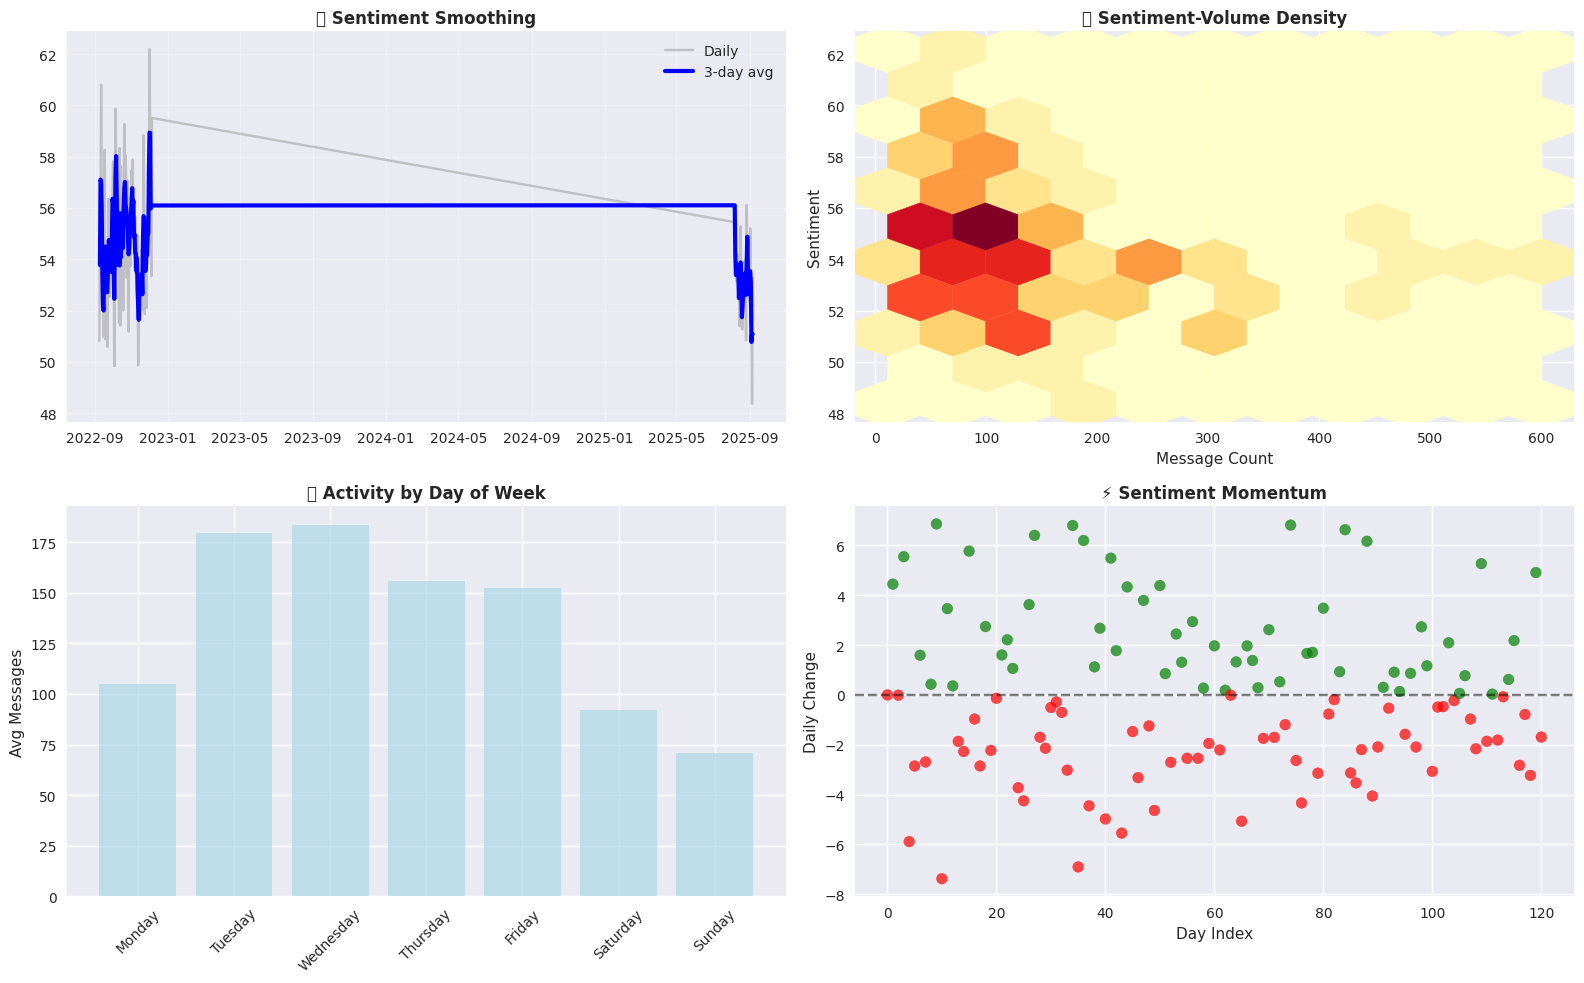

In [5]:
if not df.empty and len(df) > 3:
    # Create advanced visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Sentiment heatmap by day
    df['day_name'] = df['date'].dt.day_name()
    df['week'] = df['date'].dt.isocalendar().week
    
    # 2. Rolling averages
    if len(df) >= 3:
        df['sentiment_3d'] = df['avg_score'].rolling(window=3, center=True).mean()
        axes[0, 0].plot(df['date'], df['avg_score'], alpha=0.4, label='Daily', color='gray')
        axes[0, 0].plot(df['date'], df['sentiment_3d'], linewidth=3, label='3-day avg', color='blue')
        axes[0, 0].set_title('📈 Sentiment Smoothing', fontweight='bold')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
    
    # 3. Sentiment vs Volume relationship
    axes[0, 1].hexbin(df['count'], df['avg_score'], gridsize=10, cmap='YlOrRd')
    axes[0, 1].set_title('🔥 Sentiment-Volume Density', fontweight='bold')
    axes[0, 1].set_xlabel('Message Count')
    axes[0, 1].set_ylabel('Sentiment')
    
    # 4. Daily activity pattern
    daily_stats = df.groupby('day_name').agg({
        'avg_score': 'mean',
        'count': 'mean'
    }).reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    
    axes[1, 0].bar(daily_stats.index, daily_stats['count'], alpha=0.7, color='lightblue')
    axes[1, 0].set_title('📅 Activity by Day of Week', fontweight='bold')
    axes[1, 0].set_ylabel('Avg Messages')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # 5. Sentiment momentum
    if 'sentiment_change' in df.columns:
        momentum_colors = ['green' if x > 0 else 'red' for x in df['sentiment_change'].fillna(0)]
        axes[1, 1].scatter(range(len(df)), df['sentiment_change'].fillna(0), 
                          c=momentum_colors, alpha=0.7, s=60)
        axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
        axes[1, 1].set_title('⚡ Sentiment Momentum', fontweight='bold')
        axes[1, 1].set_ylabel('Daily Change')
        axes[1, 1].set_xlabel('Day Index')
    
    plt.tight_layout()
    plt.show()

## 🎯 Quick Analysis Functions

Run different time periods quickly:

In [ ]:
def quick_analysis(days):
    """Run quick analysis for specified days"""
    print(f'🚀 Quick {days}-day analysis...')
    records = run_simple_analysis(days_back=days)
    df = load_and_prepare_data()
    
    if not df.empty:
        avg_sentiment = df['avg_score'].mean()
        total_msgs = df['count'].sum()
        
        print(f'📊 Average Sentiment: {avg_sentiment:.1f}/100')
        print(f'💬 Total Messages: {total_msgs:,}')
        
        # Quick visualization
        plt.figure(figsize=(12, 4))
        plt.plot(df['date'], df['avg_score'], marker='o', linewidth=2)
        plt.axhline(y=50, color='gray', linestyle='--', alpha=0.7)
        plt.title(f'📈 {days}-Day Sentiment Overview')
        plt.ylabel('Sentiment Score')
        plt.grid(True, alpha=0.3)
        plt.show()
    else:
        print('❌ No data available')

quick_analysis(1)   # Yesterday
quick_analysis(3)   # Last 3 days  
quick_analysis(14)  # Last 2 weeks